In [ ]:
pip install nflows

In [2]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import pandas as pd
import numpy as np
import math
import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.coupling import AffineCouplingTransform
from nflows.transforms.linear import NaiveLinear
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.permutations import ReversePermutation

   Annual Income  Spending Score
0             15              39
1             15              81
2             16               6
3             16              77
4             17              40


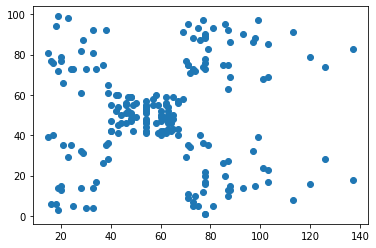

In [5]:
x = pd.read_csv("/content/drive/MyDrive/NSUT/MLIR/k_means.csv")
print(x.head())
x = np.array(x)
plt.scatter(x[:, 0], x[:, 1])

In [6]:
num_layers = 7
base_dist = StandardNormal(shape=[2])
num_iter = 10000

In [7]:
transforms = []
for _ in range(num_layers):
  transforms.append(ReversePermutation(features=2))
  transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                            hidden_features=4))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [8]:
for i in range(num_iter):
    #x, y = datasets.make_circles(n_samples=300, factor=0.5, noise=0.05)
    #x,y = datasets.make_moons(300, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [9]:
mask_1 = [0,1]
mask_2 = [1,0]
class Net(nn.Module):

    def __init__(self, in_channel, out_channels):
        super().__init__()
        layers = [nn.Linear(in_channel, in_channel)]
        for _ in range(64 - 1):
            layers.append( nn.Linear(in_channel, in_channel) )
            layers.append( nn.ReLU() )
        layers.append( nn.Linear(in_channel, out_channels) )
        self.net = nn.Sequential(*layers)

    def forward(self, inp, context=None):
        return self.net(inp)

def getNet(in_channel, out_channels):
        return Net(in_channel, out_channels)
transforms_cl = []
for _ in range(2):
     transforms_cl.append(AffineCouplingTransform(mask_1, getNet))
     transforms_cl.append(AffineCouplingTransform(mask_2, getNet))

transform_cl = CompositeTransform(transforms_cl)

flow_cl = Flow(transform_cl, base_dist)
optimizer_cl = optim.Adam(flow_cl.parameters())

In [10]:
for i in range(num_iter):
    #x, y = datasets.make_circles(n_samples=300, factor=0.5, noise=0.05)
    #x,y = datasets.make_moons(300, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer_cl.zero_grad()
    loss_cl = -flow_cl.log_prob(inputs=x).mean()
    loss_cl.backward()
    optimizer_cl.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [11]:
transforms_l = []

for _ in range(num_layers):
     transforms_l.append(ReversePermutation(features=2))
     transforms_l.append(NaiveLinear(features=2))

transform_l = CompositeTransform(transforms_l)

flow_l = Flow(transform_l, base_dist)
optimizer_l = optim.Adam(flow_l.parameters())

/usr/local/lib/python3.7/dist-packages/nflows/utils/torchutils.py:73: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1980.)
  q, _ = torch.qr(x)


In [12]:
for i in range(num_iter):
    #x, y = datasets.make_circles(n_samples=300, factor=0.5, noise=0.05)
    #x,y = datasets.make_moons(300, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer_l.zero_grad()
    loss_l = -flow_l.log_prob(inputs=x).mean()
    loss_l.backward()
    optimizer_l.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


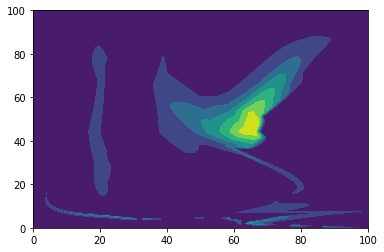

In [18]:
xline = torch.linspace(0, 100,200)
yline = torch.linspace(0, 100,200)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid = flow.log_prob(xyinput).exp().reshape(200,200)

plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
plt.title('')
plt.show()

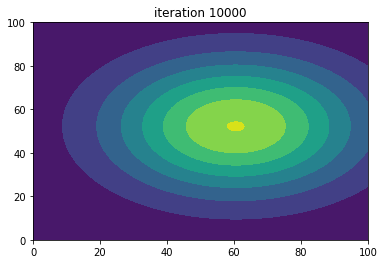

In [19]:
xline = torch.linspace(0, 100,200)
yline = torch.linspace(0, 100, 200)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid = flow_cl.log_prob(xyinput).exp().reshape(200, 200)

plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
plt.title('iteration {}'.format(i + 1))
plt.show()

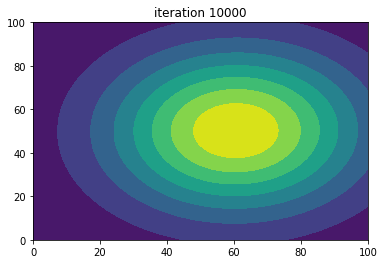

In [20]:
xline = torch.linspace(0, 100,100)
yline = torch.linspace(0, 100,100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid = flow_l.log_prob(xyinput).exp().reshape(100, 100)

plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
plt.title('iteration {}'.format(i + 1))
plt.show()

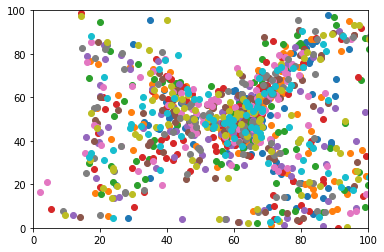

In [24]:
plt.xlim(0,100)
plt.ylim(0,100)
for i in range(10):
  samples = flow.sample(100)
  samples = samples.detach().numpy()
  plt.scatter(samples[:, 0], samples[:, 1])

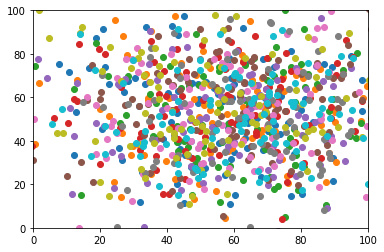

In [25]:
plt.xlim(0,100)
plt.ylim(0,100)
for i in range(10):
  samples_cl = flow_cl.sample(100)
  samples_cl = samples_cl.detach().numpy()
  plt.scatter(samples_cl[:, 0], samples_cl[:, 1])

/usr/local/lib/python3.7/dist-packages/nflows/transforms/linear.py:183: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  outputs, lu = torch.solve(outputs.t(), self._weight)  # Linear-system solver.


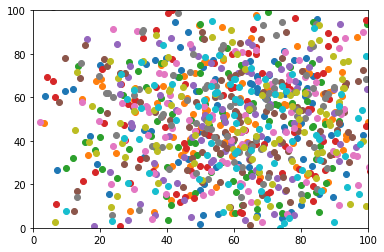

In [26]:
plt.xlim(0,100)
plt.ylim(0,100)
for i in range(10):
  samples_l = flow_l.sample(100)
  samples_l = samples_l.detach().numpy()
  plt.scatter(samples_l[:, 0], samples_l[:, 1])